## Wrapper Methods

This project is based on a survey done by Fabio Mendoza Palechor and Alexis de la Hoz Manotas that asked people about their eating habits and weight. The data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+). Categorical variables are changed to numerical ones in order to facilitate analysis.

First, I will fit a logistic regression model to try to predict whether survey respondents are obese based on their answers to questions in the survey. After that, I'll use three different wrapper methods to choose a smaller feature subset.

I'll use sequential forward selection, sequential backward floating selection, and recursive feature elimination. After implementing each wrapper method, I'll evaluate the model accuracy on the resulting smaller feature subsets and compare that with the model accuracy using all available features.

In [6]:
# Import the relevant libraries and functions to be used in this project.
import pandas as pd
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

## Evaluating a Logistic Regression Model

The data set `obesity` contains 18 predictor variables. Here's a brief description of them.

* `Gender` is `1` if a respondent is male and `0` if a respondent is female.
* `Age` is a respondent's age in years.
* `family_history_with_overweight` is `1` if a respondent has family member who is or was overweight, `0` if not.
* `FAVC` is `1` if a respondent eats high caloric food frequently, `0` if not.
* `FCVC` is `1` if a respondent usually eats vegetables in their meals, `0` if not.
* `NCP` represents how many main meals a respondent has daily (`0` for 1-2 meals, `1` for 3 meals, and `2` for more than 3 meals).
* `CAEC` represents how much food a respondent eats between meals on a scale of `0` to `3`.
* `SMOKE` is `1` if a respondent smokes, `0` if not.
* `CH2O` represents how much water a respondent drinks on a scale of `0` to `2`.
* `SCC` is `1` if a respondent monitors their caloric intake, `0` if not.
* `FAF` represents how much physical activity a respondent does on a scale of `0` to `3`.
* `TUE` represents how much time a respondent spends looking at devices with screens on a scale of `0` to `2`.
* `CALC` represents how often a respondent drinks alcohol on a scale of `0` to `3`.
* `Automobile`, `Bike`, `Motorbike`, `Public_Transportation`, and `Walking` indicate a respondent's primary mode of transportation. Their primary mode of transportation is indicated by a `1` and the other columns will contain a `0`.

The outcome variable, `NObeyesdad`, is a `1` if a patient is obese and a `0` if not.

Use the `.head()` method and inspect the data.

In [168]:
# https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+
#The majority of the data in this dataset is not yet suitable for analysis and must first be transformed/cleaned.
#The categorical variables will be manually encoded to binary or numerical formats.
# Load the data
obesity = pd.read_csv("obesity.csv")
#Clean data (conver categorical to binary) according to variable descriptions above
obese = {'Obesity_Type_I': 1, 'Obesity_Type_II': 1, 'Obesity_Type_III': 1}
CAEC = {'No': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3, 'no': 0}
conversion = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
obesity['Gender'] = obesity.apply(lambda row: 1 if row['Gender'] == 'Male' else 0, axis = 1)
obesity = obesity.drop(columns = ['Height', 'Weight'])
obesity['family_history_with_overweight'] = obesity.apply(lambda row: 1 if row['family_history_with_overweight'] == 'yes' else 0, axis = 1)
obesity['FAVC'] = obesity.apply(lambda row: 1 if row['FAVC'] == 'yes' else 0, axis = 1)
# obesity['FCVC'] = obesity.apply(lambda row: 1 if row['FCVC'] == 3.0 or row['FCVC'] == 2.0  else 0, axis = 1)
obesity['CAEC'] = obesity['CAEC'].map(CAEC)
obesity['SMOKE'] = obesity.apply(lambda row: 1 if row['SMOKE'] == 'yes' else 0, axis = 1)
obesity['SCC'] = obesity.apply(lambda row: 1 if row['SCC'] == 'yes' else 0, axis = 1)
obesity['CALC'] = obesity['CALC'].map(conversion)
mtrans = pd.get_dummies(obesity['MTRANS'])
obesity = obesity.join(mtrans)
obesity = obesity.drop(columns=['MTRANS'])
obesity['NObeyesdad1'] = obesity.apply(lambda row: 1 if row['NObeyesdad'] in obese else 0, axis = 1)
obesity = obesity.drop(columns = 'NObeyesdad')
obesity = obesity.rename(columns = {'NObeyesdad1': 'NObeyesdad'})
obesity.head()
# print(obesity['CH2O'].value_counts())
# Inspect the data


,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking,NObeyesdad
0,0,21.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,0,0,0,1,0,0
1,0,21.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,0,0,0,1,0,0
2,1,23.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,0,0,0,1,0,0
3,1,27.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,0,0,0,0,1,0
4,1,22.0,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,0,0,0,1,0,0


### Split the data into `X` and `y`

In order to use a linear regression model, I'll split the data into two parts: the predictor variables and an outcome variable. This is done by splitting the data into a DataFrame of predictor variables called `X` and a Series of outcome variables `y`.

In [229]:
#Separate data into X (independent variables) and y (outcome variable)
X = obesity.iloc[:, :-1]
y = obesity.iloc[:, -1]


### Logistic regression model

Creating a logistic regression model called `lr` and including the parameter `max_iter=1000` to make sure that the model will converge when I try to fit it.

In [170]:
#Instantiate Logistic Regression with a max_iter value of 1000 to ensure convergence
lr = LogisticRegression(max_iter = 1000)


### Fit the model

Using the `.fit()` method on `lr` to fit the model to `X` and `y`.

In [171]:
#Fit logistic regression model to data
lr.fit(X,y)


LogisticRegression(max_iter=1000)

### Model accuracy

A model's _accuracy_ is the proportion of classes that the model correctly predicts. I will compute and print the accuracy of `lr` by using the `.score()` method. What percentage of respondents did the model correctly predict as being either obese or not obese? We will record this value to compare with the accruacy results of further analyses.

In [172]:
#Print current accuracy score of logistic regression model
print(f'The accuracy score of this logistic regression is {lr.score(X,y)*100.0}%')

The accuracy score of this logistic regression is 76.59876835622927%


## Sequential Forward Selection

Now that I've created a logistic regression model and evaluated its performance, I'm ready to do some feature selection. 

Creating a sequential forward selection model called `sfs`. 
* Making sure to set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values. 
* Also setting the parameters `k_features=9`, `scoring='accuracy'`, and `cv=0`.

In [173]:
#instantiate Sequential Feature Selection (Forward) with appropriate parameters forr 9 features
sfs = SFS(lr, forward = True, floating = False, k_features = 9, scoring = 'accuracy', cv = 0)

### Fit the model

Using the `.fit()` method on `sfs` to fit the model to `X` and `y`. This step will take some time (not more than a minute) to run.

In [174]:
#Fit sfs model to data
sfs.fit(X,y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          k_features=(9, 9), scoring='accuracy')

### Inspect the results

Now that I've run the sequential forward selection algorithm on the logistic regression model with `X` and `y` one can see what features were chosen and check the model accuracy on the smaller feature set. Printing `sfs.subsets_[9]` to inspect the results of sequential forward selection.

In [175]:
#Inspect characteristics of chosen 9 features (accuracy score, feature names, etc.)
sfs.subsets_[9]

{'feature_idx': (0, 1, 2, 3, 6, 9, 10, 14, 17),
 'cv_scores': array([0.78351492]),
 'avg_score': 0.7835149218379914,
 'feature_names': ('Gender',
  'Age',
  'family_history_with_overweight',
  'FAVC',
  'CAEC',
  'SCC',
  'FAF',
  'Bike',
  'Walking')}

### Chosen features and model accuracy

Using the dictionary `sfs.subsets_[9]` to print a tuple of chosen feature names and then using it to print the accuracy of the model after doing sequential forward selection. How does this compare to the model's accuracy on all available features?

In [193]:
#Print the names and total accuracy score of chosen features
print(f"""The chosen 9 features for the SFS model are {sfs.subsets_[9]['feature_names']} and the accuracy score for these features in this model is {sfs.subsets_[9]['avg_score']*100.0}%""")

The chosen 9 features for the SFS model are ('Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SCC', 'FAF', 'Bike', 'Walking') and the accuracy score for these features in this model is 78.35149218379914%


### Visualize model accuracy

It can be helpful to visualize the results of sequential forward selection and see how accuracy is affected as each feature is added. Using the code `plot_sfs(sfs.get_metric_dict())` to plot the model accuracy as a function of the number of features used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


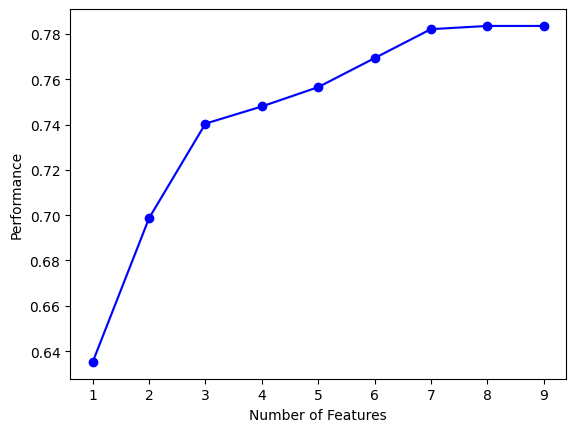

In [179]:
#Use plot_sequential_feature_selection function to plot number of features against accuracy score.
plot_sfs(sfs.get_metric_dict())
plt.show()

## Sequential Backward Selection

Sequential forward selection was able to find a feature subset that performed marginally better than the full feature set. I'll use a different sequential method and see how it compares.

Creating a sequential backward selection model called `sbs`. 
* Making sure to set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values.
* Also setting the parameters `k_features=7`, `scoring='accuracy'`, and `cv=0`.

In [183]:
#Instantiate sequential backward feature selection with appropriate parameters for 7 features.
sbs = SFS(lr, forward = False, floating = False,k_features = 7, scoring = 'accuracy', cv = 0)

### Fit the model

Using the `.fit()` method on `sbs` to fit the model to `X` and `y`.

In [184]:
#Fit the sequential backward selection to X and y
sbs.fit(X,y)

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          forward=False, k_features=(7, 7), scoring='accuracy')

### Inspect the results

Now that I've run the sequential backward selection algorithm on the logistic regression model with `X` and `y` one can see what features were chosen and check the model accuracy on the smaller feature set. Printing `sbs.subsets_[7]` to inspect the results of sequential backward selection.

In [188]:
#Print the subsets details for the sbs 7 features.
print(sbs.subsets_[7])

{'feature_idx': (1, 2, 3, 4, 6, 9, 16), 'cv_scores': array([0.76409285]), 'avg_score': 0.7640928469919469, 'feature_names': ('Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SCC', 'Public_Transportation')}


### Chosen features and model accuracy

Again, using the dictionary `sbs.subsets_[7]` to print a tuple of chosen feature names and then using it to print the accuracy of the model after doing sequential backward selection. How does this compare to the model's accuracy on all available features?

In [194]:
#Print the feature names and accuracy score for the chosen 7 features of the sbs model
print(f"""The chosen 7 features for the SBS model are {sbs.subsets_[7]['feature_names']} and the accuracy score for these features in this model is {sbs.subsets_[7]['avg_score']*100.0}%""")

The chosen 7 features for the SBS model are ('Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SCC', 'Public_Transportation') and the accuracy score for these features in this model is 76.40928469919469%


### Visualize model accuracy

One can visualize the results of sequential backward floating selection just as I did with sequential forward selection. Using the code `plot_sfs(sbs.get_metric_dict())` to plot the model accuracy as a function of the number of features used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


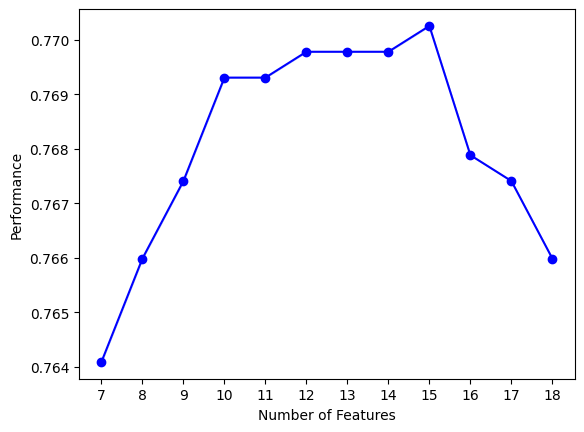

In [231]:
#Plot the number of features against the accuracy score for this SBS model.
plot_sfs(sbs.get_metric_dict())
plt.show()

## Recursive Feature Elimination

So far I've tried two different sequential feature selection methods. Trying one more: recursive feature elimination. First I'll standardize the data, then I'll fit the RFE model and inspect the results.

At a later step of this project, I'll need to be able to access feature names. Entering the code `features = X.columns` for use later.

### Standardize the data

Before applying recursive feature elimination it is necessary to standardize the data. Standardizing `X` and saving it as a DataFrame by creating a `StandardScaler()` object and using the `.fit_transform()` method.

In [240]:
#Standardize the data using the standard scaler function before using Recursive Feature Elimination to prevent interference with the importance ranking function built into RFE.
#Convert standardized numpy array to Pandas dataframe.
# X1 = pd.DataFrame(StandardScaler().fit_transform(X))
features = X.columns
scaler = StandardScaler()
X1 = scaler.fit_transform(X)
X1 = pd.DataFrame(X1, columns = features)
X1.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking
0,-1.011914,-0.522124,0.472291,-2.759769,-0.785019,0.404153,-0.300346,-0.145900,-0.013073,-0.218272,-1.188039,0.561997,-1.419172,-0.525642,-0.05768,-0.072375,0.579721,-0.165078
1,-1.011914,-0.522124,0.472291,-2.759769,1.088342,0.404153,-0.300346,6.853997,1.618759,4.581439,2.339750,-1.080625,0.521160,-0.525642,-0.05768,-0.072375,0.579721,-0.165078
2,0.988227,-0.206889,0.472291,-2.759769,-0.785019,0.404153,-0.300346,-0.145900,-0.013073,-0.218272,1.163820,0.561997,2.461491,-0.525642,-0.05768,-0.072375,0.579721,-0.165078
3,0.988227,0.423582,-2.117337,-2.759769,1.088342,0.404153,-0.300346,-0.145900,-0.013073,-0.218272,1.163820,-1.080625,2.461491,-0.525642,-0.05768,-0.072375,-1.724969,6.057758
4,0.988227,-0.364507,-2.117337,-2.759769,-0.785019,-2.167023,-0.300346,-0.145900,-0.013073,-0.218272,-1.188039,-1.080625,0.521160,-0.525642,-0.05768,-0.072375,0.579721,-0.165078


### Recursive feature elimination model

Creating an `RFE()` object that selects `8` features. Making sure to set the `estimator` parameter to `lr`.

In [237]:
#Instantiate the Recursive Feature Elimination function with parameters of estimator = lr for the logistic regression function and n_features_to_select = 8
rfe = RFE(lr, n_features_to_select = 8)

### Fit the model

Fitting the recursive feature elimination model to `X` and `y`.

In [238]:
#Fit the RFE model to X and Y.
rfe.fit(X1,y)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=8)

### Inspect chosen features

Now that I've fit the RFE model I can evaluate the results. Creating a list of chosen feature names and calling it `rfe_features`. I can use a list comprehension and filter the features in `zip(features, rfe.support_)` based on whether their support is `True` (meaning the model kept them) or `False` (meaning the model eliminated them).

In [242]:
#Create a list of the features in X before using a list comprehension to identify the 8 features chosen by the RFE model.
features1 = X1.columns
rfe_features = [f for (f,support) in zip(features1, rfe.support_) if support]
print(rfe_features)

['Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SCC', 'Automobile', 'Walking']


### Model accuracy

Using the `.score()` method on `rfe` and printing the model accuracy after doing recursive feature elimination. How does this compare to the model's accuracy on all available features?

In [243]:
print(f'The 8 features chosen by the Recursive Feature Elimination function are {rfe_features} and the accuracy score for the model with these features is {rfe.score(X,y)*100.0}%')

The 8 features chosen by the Recursive Feature Elimination function are ['Age', 'family_history_with_overweight', 'FAVC', 'FCVC', 'CAEC', 'SCC', 'Automobile', 'Walking'] and the accuracy score for the model with these features is 46.04452865940313%
